In [28]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
import pandas as pd

In [29]:
def quantize(data, n_bits):
    # 2 bits = 4 niveaux (00, 01, 10, 11)
    n_levels = 2**n_bits
    
    # Normaliser les données entre 0 et n_levels-1
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized = (data - min_vals) / (max_vals - min_vals) * (n_levels-1)
    
    # Quantifier en valeurs entières de 0 à n_levels-1
    quantized = np.round(normalized).astype(int)
    quantized = np.clip(quantized, 0, n_levels-1)
    
    return quantized



def non_uniform_quantize(data, n_bits):
    n_levels = 2 ** n_bits
    
    quantized_data = np.zeros_like(data, dtype=int)
    for col in range(data.shape[1]):
        quantiles = np.linspace(0, 1, n_levels + 1)
        thresholds = np.percentile(data[:, col], quantiles * 100)
        
        quantized_data[:, col] = np.digitize(data[:, col], thresholds[1:], right=True)
    
    return quantized_data


def export_data(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, header=False, index=False)
    print(f"Données exportées dans {filename}")

def process_dataset_from_sklearn(dataset_name, n_bits):
    if dataset_name == "iris":
        data = load_iris()
        output_file = f"data/iris_{n_bits}bits.csv"
    elif dataset_name == "wine":
        data = load_wine() 
        output_file = f"data/wine_{n_bits}bits.csv"
    else:
        raise ValueError("Dataset must be 'iris' or 'wine'")
    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = quantize(X, n_bits)
    
    # Combine features and target into one array before exporting
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)


def non_uniform_process_dataset_from_sklearn(dataset_name, n_bits):
    if dataset_name == "iris":
        data = load_iris()
        output_file = f"data/iris_non_uni_{n_bits}bits.csv"
    elif dataset_name == "wine":
        data = load_wine() 
        output_file = f"data/wine_non_uni_{n_bits}bits.csv"
    else:
        raise ValueError("Dataset must be 'iris' or 'wine'")
    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = non_uniform_quantize(X, n_bits)

    
    # Combine features and target into one array before exporting
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)




In [30]:

non_uniform_process_dataset_from_sklearn("iris", 2)

Dataset : iris
Number of samples: 150
Number of features: 4
Number of classes: 3
---
[[0 3 0 0]
 [0 1 0 0]
 [0 2 0 0]
 [0 2 0 0]
 [0 3 0 0]
 [1 3 1 1]
 [0 3 0 0]
 [0 3 0 0]
 [0 1 0 0]
 [0 2 0 0]
 [1 3 0 0]
 [0 3 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 3 0 0]
 [1 3 0 1]
 [1 3 0 1]
 [0 3 0 0]
 [1 3 1 0]
 [0 3 0 0]
 [1 3 1 0]
 [0 3 0 1]
 [0 3 0 0]
 [0 2 1 1]
 [0 3 1 0]
 [0 1 0 0]
 [0 3 0 1]
 [1 3 0 0]
 [1 3 0 0]
 [0 2 0 0]
 [0 2 0 0]
 [1 3 0 1]
 [1 3 0 0]
 [1 3 0 0]
 [0 2 0 0]
 [0 2 0 0]
 [1 3 0 0]
 [0 3 0 0]
 [0 1 0 0]
 [0 3 0 0]
 [0 3 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 3 0 1]
 [0 3 1 1]
 [0 1 0 0]
 [0 3 0 0]
 [0 2 0 0]
 [1 3 0 0]
 [0 2 0 0]
 [3 2 2 2]
 [2 2 2 2]
 [3 2 2 2]
 [1 0 1 1]
 [3 0 2 2]
 [1 0 2 1]
 [2 2 2 2]
 [0 0 1 1]
 [3 1 2 1]
 [1 0 1 2]
 [0 0 1 1]
 [2 1 1 2]
 [2 0 1 1]
 [2 1 2 2]
 [1 1 1 1]
 [3 2 2 2]
 [1 1 2 2]
 [1 0 1 1]
 [2 0 2 2]
 [1 0 1 1]
 [2 2 2 2]
 [2 0 1 1]
 [2 0 2 2]
 [2 0 2 1]
 [2 1 1 1]
 [3 1 2 2]
 [3 0 2 2]
 [3 1 2 2]
 [2 1 2 2]
 [1 0 1 1]
 [1 0 1 1]
 [1 0 1 1]
 [1 0 1 1]
 [

In [49]:
# process_dataset_from_sklearn("wine", 4)

In [50]:
import pandas as pd
def calculate_column_mean(csv_file, column_index):
    """
    Calculate mean of a specific column from a CSV file
    
    Args:
        csv_file (str): Path to the CSV file
        column_index (int): Index of the column to calculate mean for
        
    Returns:
        float: Mean value of the specified column
    """
    # Read CSV into DataFrame without headers
    df = pd.read_csv(csv_file, header=None)
    
    # Calculate mean of specified column
    column_mean = df[column_index].mean()
    
    return column_mean




In [31]:
uniform_acc = calculate_column_mean("logs/iris_2bits_4_10_clear.csv", 0)
print(f"Mean accuracy with uniform quantization : {uniform_acc}")
non_uniform_acc = calculate_column_mean("logs/iris_non_uni_2bits_4_10_clear.csv", 0)
print(f"Mean accuracy with non uniform quantization: {non_uniform_acc}")


FileNotFoundError: [Errno 2] No such file or directory: 'logs/iris_2bits_4_64_clear.csv'

Dataset : wine
Number of samples: 178
Number of features: 13
Number of classes: 3
---
Données exportées dans data/wine_4bits.csv


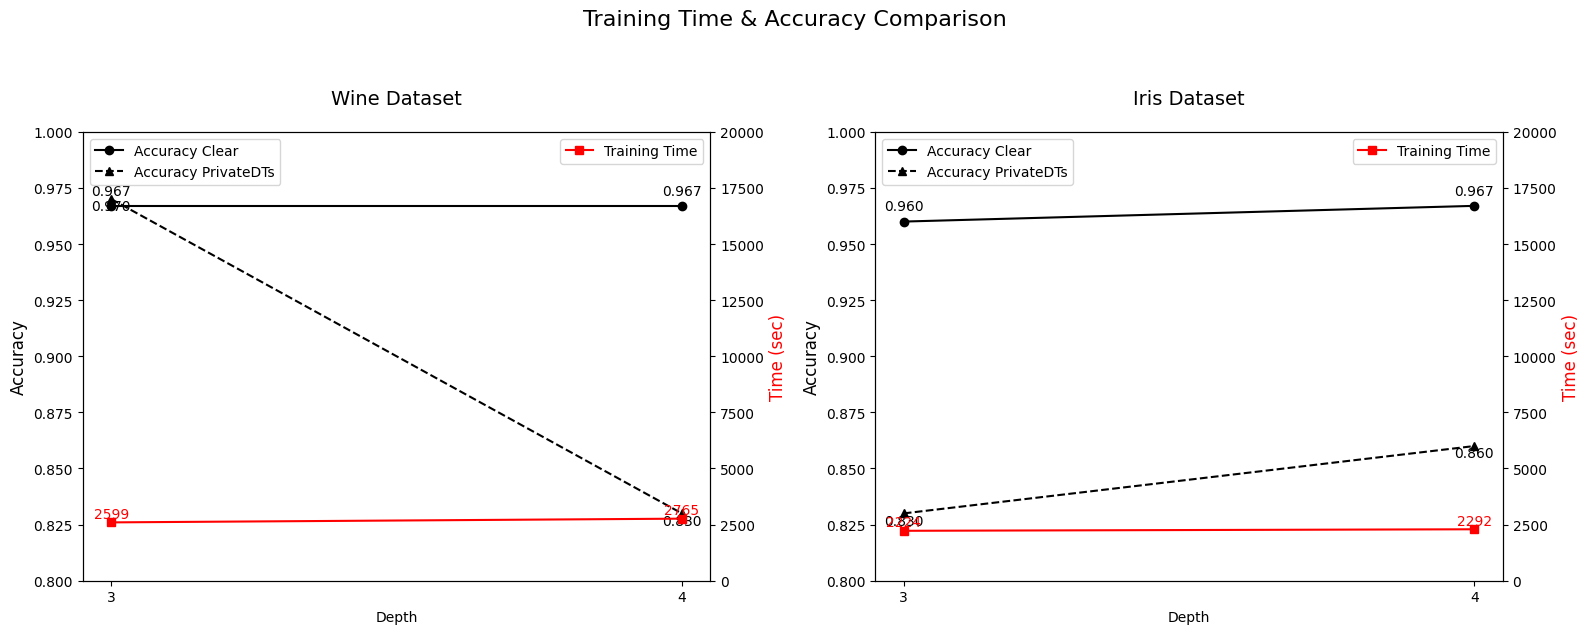

In [ ]:
import matplotlib.pyplot as plt

# Données pour reproduire le graphique
depth = [1, 2, 3, 4]  # Profondeur
accuracy_clear_wine = [None, None, 0.967, 0.967]
accuracy_private_wine = [None, None, 0.97, 0.83]
training_time_wine = [None, None, 2599, 2765]

accuracy_clear_iris = [None, None, 0.960, 0.967]
accuracy_private_iris = [None, None, 0.83, 0.86]
training_time_iris = [None, None, 2224, 2292]

# Créer deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique pour Wine
ax1_twin = ax1.twinx()
ax1.set_xlabel("Depth")
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_ylim(0.8, 1.0)
ax1.set_xticks(depth)
ax1.plot(depth[2:], accuracy_clear_wine[2:], 'o-', label="Accuracy Clear", color='black')
ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Wine
for i in range(2, len(depth)):
    ax1.text(depth[i], accuracy_clear_wine[i] + 0.005, f"{accuracy_clear_wine[i]:.3f}", ha='center')
    ax1.text(depth[i], accuracy_private_wine[i] - 0.005, f"{accuracy_private_wine[i]:.3f}", ha='center')

ax1_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax1_twin.set_ylim(0, 20000)
ax1_twin.plot(depth[2:], training_time_wine[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Wine)
for i in range(2, len(depth)):
    ax1_twin.text(depth[i], training_time_wine[i] + 200, f"{training_time_wine[i]}", color="red", ha='center')

# Deuxième graphique pour Iris
ax2_twin = ax2.twinx()
ax2.set_xlabel("Depth")
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(depth)
ax2.plot(depth[2:], accuracy_clear_iris[2:], 'o-', label="Accuracy Clear", color='black')
ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Iris
for i in range(2, len(depth)):
    ax2.text(depth[i], accuracy_clear_iris[i] + 0.005, f"{accuracy_clear_iris[i]:.3f}", ha='center')
    ax2.text(depth[i], accuracy_private_iris[i] - 0.005, f"{accuracy_private_iris[i]:.3f}", ha='center')

ax2_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax2_twin.set_ylim(0, 20000)
ax2_twin.plot(depth[2:], training_time_iris[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Iris)
for i in range(2, len(depth)):
    ax2_twin.text(depth[i], training_time_iris[i] + 200, f"{training_time_iris[i]}", color="red", ha='center')

# Titres et légendes
ax1.set_title("Wine Dataset", fontsize=14, pad=20)
ax2.set_title("Iris Dataset", fontsize=14, pad=20)

ax1.legend(loc="upper left")
ax1_twin.legend(loc="upper right")
ax2.legend(loc="upper left")
ax2_twin.legend(loc="upper right")

fig.suptitle("Training Time & Accuracy Comparison", fontsize=16, y=1.05)
plt.tight_layout()


plt.show()

In [8]:
import pandas as pd
def calculate_column_mean(csv_file, column_index):
    """
    Calculate mean of a specific column from a CSV file
    
    Args:
        csv_file (str): Path to the CSV file
        column_index (int): Index of the column to calculate mean for
        
    Returns:
        float: Mean value of the specified column
    """
    # Read CSV into DataFrame without headers
    df = pd.read_csv(csv_file, header=None)
    
    # Calculate mean of specified column
    column_mean = df[column_index].mean()
    
    return column_mean




Mean accuracy wine 4 bits: 0.8342857142857143


In [22]:
acc_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 0)
print(f"Mean accuracy wine depth 4 : {acc_wine_mean_4}")
acc_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 0)
print(f"Mean accuracy wine depth 3 : {acc_wine_mean_3}")
acc_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 0)
print(f"Mean accuracy wine depth 2 : {acc_wine_mean_2}")
# acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")
time_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 1)
print(f"Mean time wine depth 4: {time_wine_mean_4}")
time_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 1)
print(f"Mean time wine depth 3 : {time_wine_mean_3}")
time_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 1)
print(f"Mean time wine depth 2 : {time_wine_mean_2}")
# acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")

Mean accuracy wine depth 4 : 0.8342857142857143
Mean accuracy wine depth 3 : 0.9714285714285714
Mean accuracy wine depth 2 : 0.43999999999999995
Mean time wine depth 4: 2765.1421420292
Mean time wine depth 3 : 2599.519727959
Mean time wine depth 2 : 682.2813054000001


In [20]:
acc_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 0)
print(f"Mean accuracy iris depth 4 : {acc_iris_mean_4}")
acc_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 0)
print(f"Mean accuracy iris depth 3 : {acc_iris_mean_3}")
# acc_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 0)
# print(f"Mean accuracy iris depth 2 : {acc_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")
time_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 1)
print(f"Mean time iris depth 4: {time_iris_mean_4}")
time_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 1)
print(f"Mean time iris depth 3 : {time_iris_mean_3}")
# time_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 1)
# print(f"Mean time iris depth 2 : {time_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")

Mean accuracy iris depth 4 : 0.8666666666666666
Mean accuracy iris depth 3 : 0.8333333333333334
Mean time iris depth 4: 2292.4217399409
Mean time iris depth 3 : 2224.951069844


/var/folders/9l/j96wlyzs6yv10sd_s6lh6cr40000gn/T/ipykernel_90728/582839107.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")
/var/folders/9l/j96wlyzs6yv10sd_s6lh6cr40000gn/T/ipykernel_90728/582839107.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")


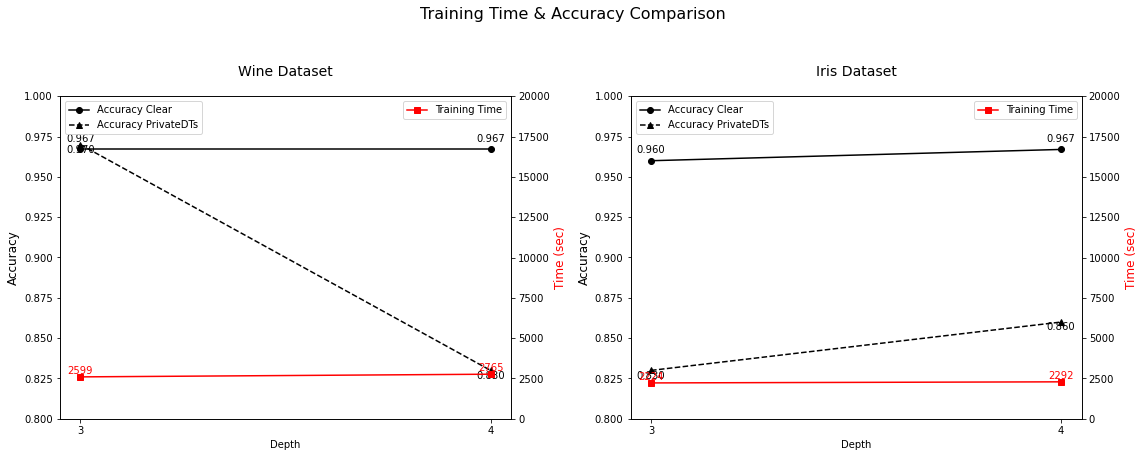

In [25]:
import matplotlib.pyplot as plt

# Données pour reproduire le graphique
depth = [1, 2, 3, 4]  # Profondeur
accuracy_clear_wine = [None, None, 0.967, 0.967]
accuracy_private_wine = [None, None, 0.97, 0.83]
training_time_wine = [None, None, 2599, 2765]

accuracy_clear_iris = [None, None, 0.960, 0.967]
accuracy_private_iris = [None, None, 0.83, 0.86]
training_time_iris = [None, None, 2224, 2292]

# Créer deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique pour Wine
ax1_twin = ax1.twinx()
ax1.set_xlabel("Depth")
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_ylim(0.8, 1.0)
ax1.set_xticks(depth)
ax1.plot(depth[2:], accuracy_clear_wine[2:], 'o-', label="Accuracy Clear", color='black')
ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Wine
for i in range(2, len(depth)):
    ax1.text(depth[i], accuracy_clear_wine[i] + 0.005, f"{accuracy_clear_wine[i]:.3f}", ha='center')
    ax1.text(depth[i], accuracy_private_wine[i] - 0.005, f"{accuracy_private_wine[i]:.3f}", ha='center')

ax1_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax1_twin.set_ylim(0, 20000)
ax1_twin.plot(depth[2:], training_time_wine[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Wine)
for i in range(2, len(depth)):
    ax1_twin.text(depth[i], training_time_wine[i] + 200, f"{training_time_wine[i]}", color="red", ha='center')

# Deuxième graphique pour Iris
ax2_twin = ax2.twinx()
ax2.set_xlabel("Depth")
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(depth)
ax2.plot(depth[2:], accuracy_clear_iris[2:], 'o-', label="Accuracy Clear", color='black')
ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Iris
for i in range(2, len(depth)):
    ax2.text(depth[i], accuracy_clear_iris[i] + 0.005, f"{accuracy_clear_iris[i]:.3f}", ha='center')
    ax2.text(depth[i], accuracy_private_iris[i] - 0.005, f"{accuracy_private_iris[i]:.3f}", ha='center')

ax2_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax2_twin.set_ylim(0, 20000)
ax2_twin.plot(depth[2:], training_time_iris[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Iris)
for i in range(2, len(depth)):
    ax2_twin.text(depth[i], training_time_iris[i] + 200, f"{training_time_iris[i]}", color="red", ha='center')

# Titres et légendes
ax1.set_title("Wine Dataset", fontsize=14, pad=20)
ax2.set_title("Iris Dataset", fontsize=14, pad=20)

ax1.legend(loc="upper left")
ax1_twin.legend(loc="upper right")
ax2.legend(loc="upper left")
ax2_twin.legend(loc="upper right")

fig.suptitle("Training Time & Accuracy Comparison", fontsize=16, y=1.05)
plt.tight_layout()


plt.show()